In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import packages.mine_generic as mine_g
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## 2.2. Feature extraction:
Let's do PCA, with food first. Here I need to do:

1. PCA is factors + lagged of yt-i
-> need to figure out the number of factors + lags of y
2. Feed PCA with 95% explained variance + tree-based models.


In [2]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
hicp_cat_path = 'data/preprocessed/food_yoy_infl.csv'
category = 'Food'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
X_cat_train, y_cat_train = mine_g.split_train_set(X_df=cat_df,
                                           y=HICP_cat, 
                                           h = 1)

Number of items in Food group:  180
Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


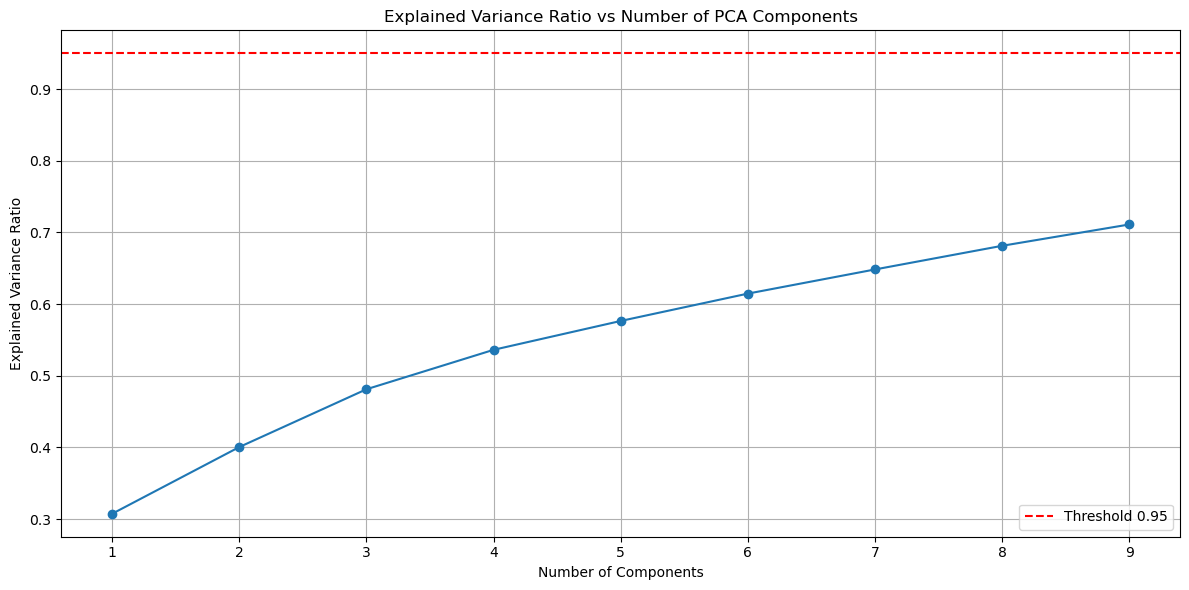

In [75]:

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_cat_train)

# Define a range of n_components to explore
n_components_range = range(1, 10, 1)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### 1. Choose r = 5, tune the lags for h = 1:

In [5]:
X_cat_train, y_cat_train = mine_g.split_train_set(X_df=cat_df,
                                           y=HICP_cat, 
                                           h = 1)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


In [6]:
X_train, X_test = cat_df[cat_df.index <= '2015-12-31'].fillna(0), cat_df[cat_df.index > '2015-12-31'].fillna(0)
y_train, y_test = HICP_cat[HICP_cat.index <= '2015-12-31'], HICP_cat[(HICP_cat.index > '2015-12-31') & (HICP_cat.index <= '2022-12-31')]

In [7]:
import statsmodels.api as sm

max_lag = 12

def train_pca(X_train,n_components):
    #X_train = cat_df[cat_df.index <= '2015-12-31'].fillna(0)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    pca = PCA(n_components = n_components)

    factor_train = pd.DataFrame(pca.fit_transform(X_train_scaled))
    return factor_train


# Function to fit OLS model with a given lag length and calculate BIC
def tune_lags_pca_regress_bic(X_train, y_train, lags, horizon = 1):

    print(f'Horizon {horizon}, lag {lags}')

    # PCA:
    X_train_temp = X_train.iloc[:-horizon, :]

    factor_train, _ = train_pca(X_train_temp,n_components=5)
    # lagged values of y:
    y_lagged = pd.DataFrame()
    for lag in range(0, lags + 1):
        y_lagged[f'Lag_{lag}'] = y_train.shift(lag)

    # Combine lagged values and additional predictors
    X_pca_with_lags = pd.concat([y_lagged.reset_index(), factor_train], axis= 1)
    X_pca_with_lags.dropna(inplace=True)
    X_pca_with_lags = X_pca_with_lags.reset_index(drop=True)

    date_here = X_pca_with_lags.loc[:, 'date']
    X_pca_with_lags = X_pca_with_lags.drop(columns='date')
    X_pca_with_lags_with_const = sm.add_constant(X_pca_with_lags)

    # y:
    y_train_temp = y_train[lags+horizon:]
    print(f'X period: {date_here.iloc[0]} - {date_here.iloc[-1]}')
    print(f'y period: {y_train_temp.index[0]} - {y_train_temp.index[-1]}')


    # Fit OLS regression model
    model = sm.OLS(y_train_temp.reset_index(drop = True), X_pca_with_lags_with_const)
    results = model.fit()
    
    # Calculate BIC
    bic = results.bic
    
    return bic


In [8]:
bic_values_h1 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=1)
    bic_values_h1.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h1)
lowest_bic = min(bic_values_h1)

print("BIC values for different lag lengths:", bic_values_h1)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)


Horizon 1, lag 0
X period: 1997-01-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-02-28 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 1
X period: 1997-02-28 00:00:00 - 2015-11-30 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 2
X period: 1997-03-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 3
X period: 1997-04-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 4
X period: 1997-05-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 5
X period: 1997-06-30 00:00:00 - 2015-11-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 6
X period: 1997-07-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 7
X period: 1997-08-31 00:00:00 - 2015-11-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 1, lag 8
X period: 1997-

In [10]:
bic_values_h3 = []

for lags in range(0, max_lag+1):
    bic= tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=3)
    bic_values_h3.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h3)
lowest_bic = min(bic_values_h3)

print("BIC values for different lag lengths:", bic_values_h3)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 3, lag 0
X period: 1997-01-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 1
X period: 1997-02-28 00:00:00 - 2015-09-30 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 2
X period: 1997-03-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 3
X period: 1997-04-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 4
X period: 1997-05-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 5
X period: 1997-06-30 00:00:00 - 2015-09-30 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 6
X period: 1997-07-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 7
X period: 1997-08-31 00:00:00 - 2015-09-30 00:00:00
y period: 1997-11-30 00:00:00 - 2015-12-31 00:00:00
Horizon 3, lag 8
X period: 1997-

### 2. Use it to do recursive forecast:
retrain the model with n_components = 5 and lag = 12, horizon = 1.

In [77]:
# Set up parameters:
horizon = 1
lags = 12
n_components = 5

cat_df.fillna(0, inplace=True)

X_train = cat_df[cat_df.index <= '2015-12-31'].iloc[:-horizon, :]
X_test = cat_df.loc[~cat_df.index.isin(X_train.index)]

y_train = HICP_cat[HICP_cat.index <= '2015-12-31'].iloc[horizon:, :]
y_test = HICP_cat[(HICP_cat.index > '2015-12-31') & (HICP_cat.index <= '2022-12-31')]

In [55]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# PCA:
pca = PCA(n_components = n_components)

factor_train = pd.DataFrame(pca.fit_transform(X_train_scaled))
factor_test = pd.DataFrame(pca.transform(X_test_scaled))

# Create y_lagged:

y_lagged = pd.DataFrame()
for lag in range(0, lags + 1):
    y_lagged[f'Lag_{lag}'] = HICP_cat[HICP_cat.index <= '2022-12-31'].shift(lag)


# concatenate all:
X_factor_all = pd.concat([factor_train, factor_test], axis = 0, ignore_index=True)
factor_col_name = {col: f'factor_{col}' for col in X_factor_all.columns}
X_factor_all.rename(columns=factor_col_name, inplace=True)

X_factor_lags_all = pd.concat([y_lagged.reset_index(), X_factor_all], axis=1)
#X_factor_lags_all.set_index(0, drop=True)
#X_factor_lags_all.dropna(inplace=True)
X_factor_lags_all.set_index('date', drop=True, inplace=True)

# 
N, T = len(X_train), len(X_test)

In [86]:
# Recursive forecast

predictions = []

for i in range(T-horizon):

    X_train_pca_temp = X_factor_lags_all.iloc[lags:N+i, :]
    print(X_train_pca_temp.index[0], X_train_pca_temp.index[-1])
    X_test_pca_temp = X_factor_lags_all.iloc[N+i:N+i+1, :]
    y_train_temp = HICP_cat[lags+horizon:N+i+1]
    print(y_train_temp.index[0], y_train_temp.index[-1])

    # Model:
    model = LinearRegression()
    model.fit(X_train_pca_temp, y_train_temp)
    y_pred = model.predict(X_test_pca_temp)
    print(X_test_pca_temp.index)
    predictions.append(y_pred[0][0])
    
    print('---')


1998-01-31 00:00:00 2015-11-30 00:00:00
1998-02-28 00:00:00 2015-12-31 00:00:00
DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2015-12-31 00:00:00
1998-02-28 00:00:00 2016-01-31 00:00:00
DatetimeIndex(['2016-01-31'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2016-01-31 00:00:00
1998-02-28 00:00:00 2016-02-29 00:00:00
DatetimeIndex(['2016-02-29'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2016-02-29 00:00:00
1998-02-28 00:00:00 2016-03-31 00:00:00
DatetimeIndex(['2016-03-31'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2016-03-31 00:00:00
1998-02-28 00:00:00 2016-04-30 00:00:00
DatetimeIndex(['2016-04-30'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2016-04-30 00:00:00
1998-02-28 00:00:00 2016-05-31 00:00:00
DatetimeIndex(['2016-05-31'], dtype='datetime64[ns]', name='date', freq=None)
---
1998-01-31 00:00:00 2016-05-

In [ ]:
food_cat_prediction = pd.DataFrame(index=y_test.index)
food_cat_prediction.loc[:, f'pred_{category}_h_{horizon}'] = predictions

In [ ]:
bic_values_h2 = []

for lags in range(0, max_lag+1):
    bic = tune_lags_pca_regress_bic(X_train, y_train, lags, horizon=2)
    bic_values_h2.append(bic)

# Find the lag length with the lowest BIC
optimal_lag = np.argmin(bic_values_h2)
lowest_bic = min(bic_values_h2)

print("BIC values for different lag lengths:", bic_values_h2)
print("Optimal lag length chosen by BIC:", optimal_lag)
print("Lowest BIC:", lowest_bic)

Horizon 2, lag 0
X period: 1997-01-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-03-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 1
X period: 1997-02-28 00:00:00 - 2015-10-31 00:00:00
y period: 1997-04-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 2
X period: 1997-03-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-05-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 3
X period: 1997-04-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-06-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 4
X period: 1997-05-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-07-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 5
X period: 1997-06-30 00:00:00 - 2015-10-31 00:00:00
y period: 1997-08-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 6
X period: 1997-07-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-09-30 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 7
X period: 1997-08-31 00:00:00 - 2015-10-31 00:00:00
y period: 1997-10-31 00:00:00 - 2015-12-31 00:00:00
Horizon 2, lag 8
X period: 1997-